# *eht-imaging* Polarization Tutorial


In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import ehtim as eh
from   ehtim.calibrating import self_cal as sc
ttype='nfft'

Welcome to eht-imaging! v 1.2.8 



## Load an image 

In [2]:
# Load the image and the telescope array
im = eh.image.load_image('../models/avery_sgra_eofn.txt')
eht = eh.array.load_txt('../arrays/EHT2017.txt')

Loading text image:  ../models/avery_sgra_eofn.txt


In [ ]:
# create directory for results
outpath = './tutorial_results/ehtim_tutorial_pol'
if not os.path.exists(os.path.dirname(outpath)):
    os.makedirs(os.path.dirname(outpath))

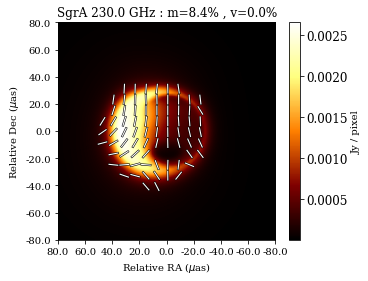

In [3]:
# Plot polarization ticks
im.display(plotp=True,pcut=0.1); #pcut controls the location where ticks appear



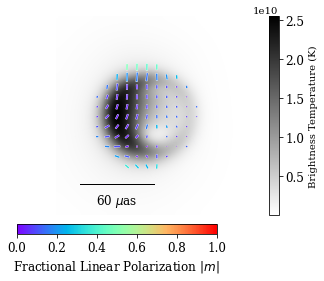

In [9]:
im.blur_circ(10*eh.RADPERUAS).display(
                 plotp=True,pcut=0.1,mcut=0,
                 label_type='scale',scalecolor='k',
                 cfun='gray_r',cbar_unit=['Tb'],
                 vec_cfun='rainbow',nvec=20,vec_cbar_lims=(0,1),scale_ticks=True,
                 has_title=False);

## Generate a synthetic observation

In [ ]:
# simulate and save an EHT observation
# ampcal and phasecal determine if gain variations and phase errors are included
tint_sec = 60 #integration time in seconds, 
tadv_sec = 600 #advance time between scans
tstart_hr = 0 #GMST time of the start of the observation
tstop_hr = 24 #GMST time of the end of the observation
bw_hz = 4.e9 #bandwidth in Hz
obs = im.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                 sgrscat=False, ampcal=True, phasecal=False, ttype='direct')
obs.save_uvfits(outpath+'.uvfits')

In [ ]:
# What is the resolution of the observation? 
beamparams = obs.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res = obs.res() # nominal array resolution, 1/longest baseline
print("Clean beam parameters: [%.1f uas,%.1f uas,%.1f deg]"
      %(beamparams[0]/eh.RADPERUAS, beamparams[1]/eh.RADPERUAS,beamparams[2]/eh.DEGREE))
print("Nominal Resolution: %.1f uas"%(res/eh.RADPERUAS))

## Perform Total Intensity Imaging

In [ ]:
npix = 64
fov = 160*eh.RADPERUAS
zbl = im.total_flux() # total flux
prior_fwhm = 100*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
gaussprior.display();

In [ ]:
# Image total intensity
imgr  = eh.imager.Imager(obs, gaussprior, prior_im=gaussprior, flux=zbl,
                         data_term = {'amp':1, 'cphase':0.5},
                         reg_term={'tv':0.05, 'l1':0.1},
                         norm_reg=True, # this is very important!
                         epsilon_tv = 1.e-10,
                         maxit=250, ttype='direct')
imgr.make_image_I(grads=True,show_updates=False)

# Blur the image with a circular beam and image again to help convergance
out = imgr.out_last()
imgr.init_next = out.blur_circ(res)
imgr.make_image_I(show_updates=False)

out = imgr.out_last()
imgr.init_next = out.blur_circ(res)
imgr.maxit_next=500
imgr.make_image_I(show_updates=False)

In [ ]:
# Investigate output
out=imgr.out_last().threshold(0.01)
out.display();
out.blur_circ(0.5*res).display();

## Perform Polarization Imaging on Fixed Stokes I background

In [ ]:
# Image polarization with the polarimetric ratio as main data product
imgr.init_next = out.blur_circ(0.25*res)
imgr.transform_next = 'mcv'
imgr.dat_term_next = {'m':1}
imgr.reg_term_next = {'hw':1,'ptv':1}
imgr.make_image_P(show_updates=False)

In [ ]:
# Display Result
out=imgr.out_last()
out.display(plotp=True,pcut=0.1);

In [ ]:
# blur and image again with the polarimetric ratio as data
imgr.init_next = out.blur_circ(0,.5*res) # you need the extra argument to blur_circ to blur polarization!
imgr.transform_next = 'mcv'
imgr.dat_term_next = {'m':5}
imgr.reg_term_next = {'hw':1,'ptv':1}
imgr.make_image_P(show_updates=False)

In [ ]:
# Display Result
out=imgr.out_last()
out.display(plotp=True,pcut=0.1);

In [ ]:
# self-calibrate the data to the last image
out=imgr.out_last()
obs_sc = eh.selfcal(obs,out,ttype='nfft',use_grad=True,processes=-1) 

In [ ]:
# image again using the self-calibrated data
# image both total intensity and polarization simulatneously
imgr.init_next = out.blur_circ(0,res) # you need the extra argument to blur_circ to blur polarization!
imgr.obs_next = obs_sc # replace the observationwith the self-calibrated version
imgr.transform_next = 'mcv'
imgr.dat_term_next = {'amp':1, 'cphase':0.5,'pvis':1}  # you need data terms for both total intensity and pol
imgr.reg_term_next = {'tv':0.05,'hw':1,'ptv':1} # you need regulraizer terms for both as well
imgr.make_image_IP(show_updates=False)

In [ ]:
# Display Result
imgr.out_last().display(plotp=True,pcut=0.1);
im.display(plotp=True,pcut=0.1);

In [ ]:
# save the output
out.save_fits(outpath+'_output.fits')